<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN%2BReconstructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up environement & params

In [1]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)
# params
noise_dim = 100
batch_size = 16
half_batch_size = int(batch_size/2)
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 10
img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1 # x = |x| >= thr_value ? x : 0

# optimizer - LR and Beta1 are hyper parameters
optimizer = Adam(0.0002,0.5)

train_only_fours = False  # overfit to 4 creation - sanity check
warm_start_discriminator = False # init discriminator by training it *a little bit* as classifier
load_dict = True  #load pretrained dictionary
use_noisy_labels = False # use soft labels and not 0,1 to train
use_reconstructor = False
#
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Using TensorFlow backend.


Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


import data set + preprocessing

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

# take only digit 4
x_four_digit = x_train[y_train==4]
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_four_digit = x_four_digit.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_test = x_test.reshape(-1, img_rows*img_cols*channels) # each image as vector
np.random.shuffle(x_train)
np.random.shuffle(x_four_digit)
print(x_train.shape)
print(x_four_digit.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(5842, 784)


load dictionary from pickle

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path

#dictionary file name
file_name = 'dictionary20.pkl'

#check if dictionary exists
if not path.exists(file_name):
  sparse_dim = 3000
  d=DictionaryLearning(n_components=sparse_dim, max_iter=10)
  # train dictionary
  d.fit(x_train[1:10000, :])
  dictionary_loaded2 = np.transpose(d.components_)
  print(dictionary.shape)

  with open(file_name, 'wb') as output:
    pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
  print("created new dictionary")

else:
  with open(file_name, 'rb') as input:
    d = pickle.load(input)
    dictionary_loaded2 = np.transpose(d.components_)
  # print(d)
  print("loaded dictionary")

loaded dictionary


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DictionaryLearning from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


load transformed data set

In [10]:
from numpy import loadtxt
transformed_x = loadtxt('transformed_x.csv', delimiter=',')

ValueError: ignored

In [0]:
transformed_x = d.transform(x_train)

In [14]:
transformed_x.shape

(60000, 784)

create reconstructor model

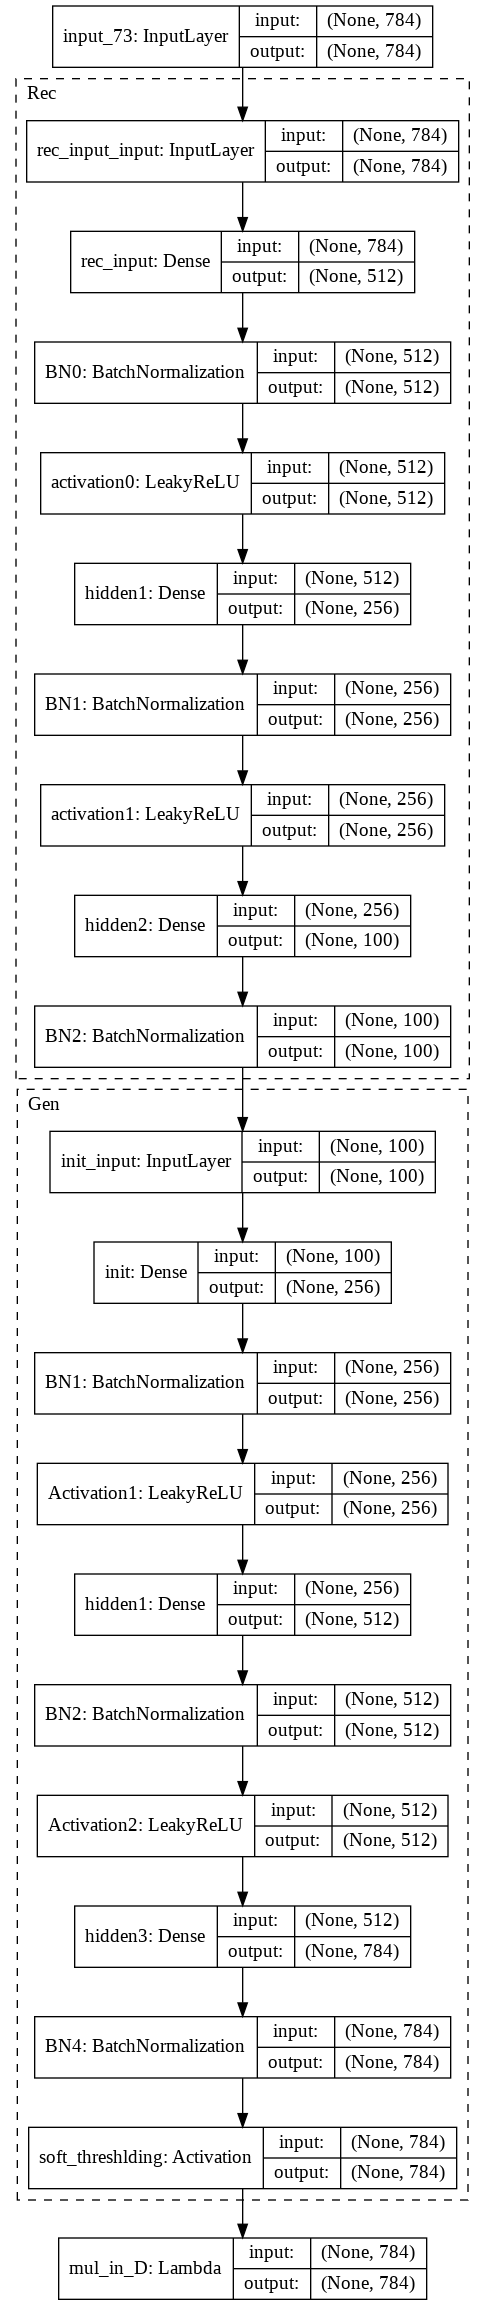

In [218]:
# with pursuit and thresholding approach
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout,AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation, GaussianNoise
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast
from keras.activations import sigmoid
from keras.utils import np_utils
from keras.backend import random_normal,shape,exp


# costum loss - TODO:: parameter to TUNE
def gaussian_prob_loss(y_actual,y_pred):
  probs = 1 - K.square(K.exp(-0.5*K.square(y_pred)))    #1 - prob of y_pred to be drawn from gaussian with mu = 0, std = 1
  return probs



# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)



get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})



# classifier
def create_trained_classifier():
    classifier = Sequential()
    #16 - better
    classifier.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    classifier.add(BatchNormalization(name="BN0"))
    classifier.add(LeakyReLU(0.2,name="Activation0"))
    #32 - better
    classifier.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    classifier.add(BatchNormalization(name="BN1"))
    classifier.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    classifier.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    classifier.add(BatchNormalization(name="BN2"))
    classifier.add(LeakyReLU(0.2,name="Activation2"))
    
    classifier.add(Flatten(name="Flatten"))
    classifier.add(Dropout(0.4,name="dropout"))
    classifier.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    classifier.trainable = True
    classifier.compile(loss='categorical_crossentropy', optimizer=optimizer)

    model=classifier.fit(x_train.reshape(-1,img_rows,img_cols,channels), y_train, 
                              validation_data=(x_test.reshape(-1,img_rows,img_cols,channels), y_test), epochs=5, batch_size=64)
    return classifier
# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_discriminator():
  if(warm_start_discriminator):
    classifier = create_trained_classifier()
    classifier.pop()
    classifier.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    classifier.trainable = True
    classifier.compile(loss=my_loss, optimizer=optimizer)
    return classifier
  else:
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    discriminator.add(BatchNormalization(name="BN0"))
    discriminator.add(LeakyReLU(0.2,name="Activation0"))
    # #32 - better
    # discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    # discriminator.add(BatchNormalization(name="BN1"))
    # discriminator.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    discriminator.add(BatchNormalization(name="BN2"))
    discriminator.add(LeakyReLU(0.2,name="Activation2"))
    
    discriminator.add(Flatten(name="Flatten"))
    discriminator.add(Dropout(0.4,name="dropout"))
    discriminator.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    discriminator.trainable = True
    discriminator.compile(loss=my_loss, optimizer=optimizer)
    return discriminator


# input: sparse vec size
# output: noise size
def create_encoder():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=(img_rows*img_cols*channels),name="rec_input"))
    reconstructor.add(BatchNormalization(name="BN0"))
    reconstructor.add(LeakyReLU(0.2,name="activation0"))

    reconstructor.add(Dense(256, kernel_initializer=init,name="hidden1"))
    reconstructor.add(BatchNormalization(name="BN1"))
    reconstructor.add(LeakyReLU(0.2,name="activation1"))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init,name="hidden2"))
    reconstructor.add(BatchNormalization(name="BN2"))
    #reconstructor.add(Activation(activation="tanh"))
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    # generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    # generator.add(BatchNormalization(name="BN3"))
    # generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    return generator



# build VAE
generator = create_generator()
encoder = create_encoder()
discriminator = create_discriminator()
# naming:
generator.name = "Gen"
encoder.name = "Rec"
discriminator.name = "Disc"

# define vae
vae_input = Input(shape=(sparse_dim,))
encoder_output = encoder(vae_input)
# G(z) is a sparse vector
sparse_vec = generator(encoder_output)   # sparse_dim size - it is thresholded
# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)

vae = Model(vae_input, [encoder_output, sparse_vec,fake_image_vec])  #todo add L2 on image
vae.compile(loss=[gaussian_prob_loss,'mean_absolute_error','mean_squared_error'],loss_weights=[0.1,1,1],optimizer='sgd')

gan_input = Input(shape=(noise_dim,))
# G(z) is a sparse vector
sparse_vec2 = generator(gan_input)   # sparse_dim size - it is thresholded
# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec2 = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec2)
# reshape to image size - will be inserted to discriminator
fake_image2 = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec2)
gan_output = discriminator(fake_image2)  # the descriminator output

gan = Model(gan_input,[gan_output,sparse_vec2])
gan.compile(loss=['binary_crossentropy','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])

plot_model(vae, to_file='model_plot1.png', show_shapes=True, show_layer_names=True,expand_nested=True)


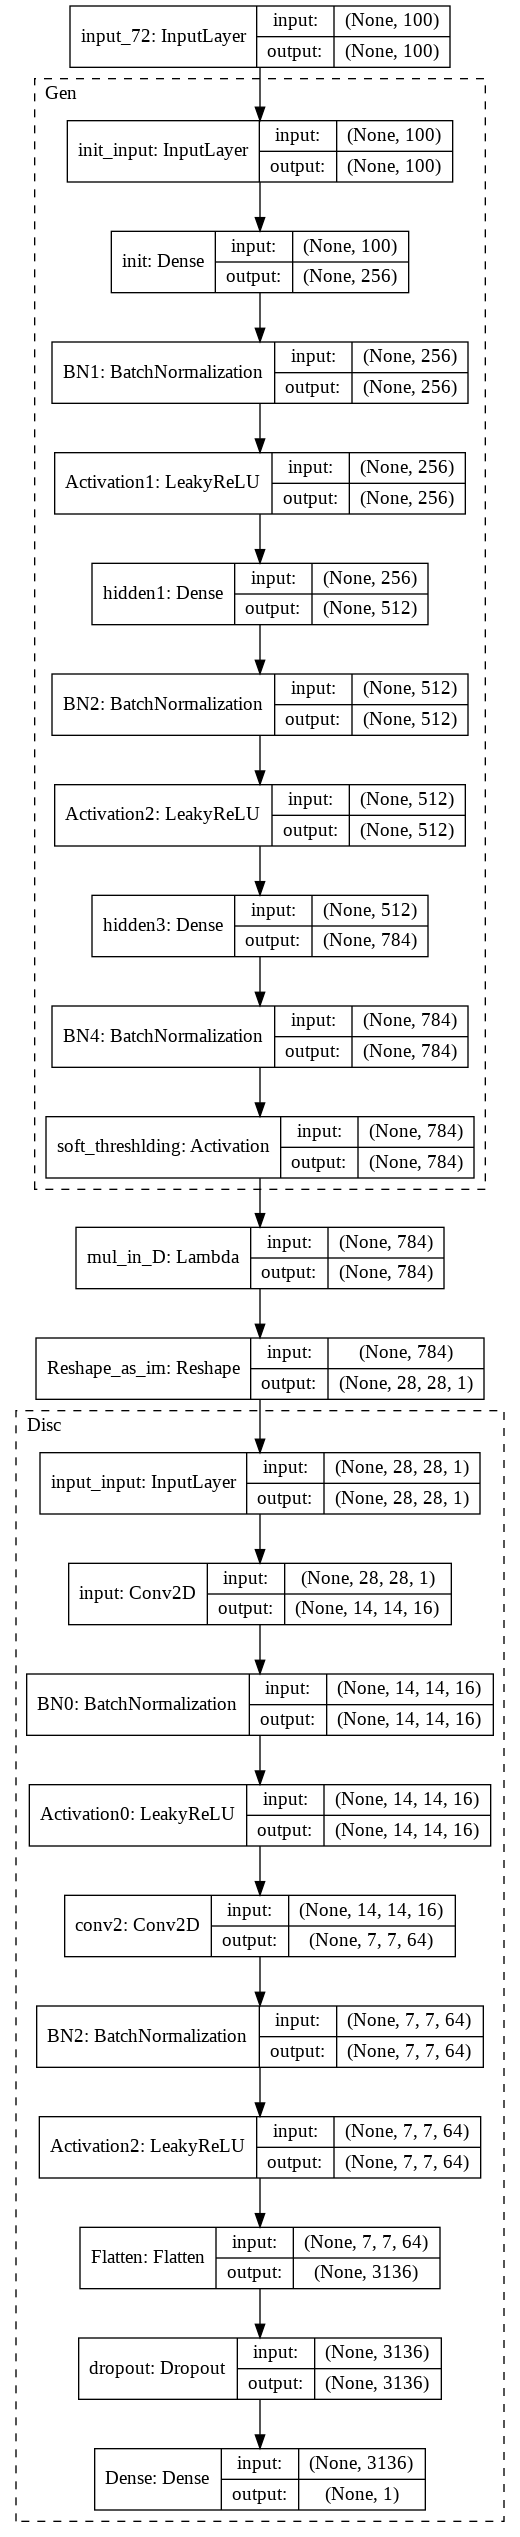

In [214]:
plot_model(gan, to_file='model_plot2.png', show_shapes=True, show_layer_names=True,expand_nested=True)

train AE

In [215]:
zeros = np.zeros(60000*100)
zeros = zeros.reshape(60000,100)
vae.fit(transformed_x,[zeros,transformed_x,x_train],epochs = 10, shuffle=True)

Epoch 1/10
60000/60000 [==============================] - 75s 1ms/step - loss: 1.0045 - Rec_loss: 0.3140 - Gen_loss: 0.6468 - mul_in_D_loss: 0.3263
Epoch 2/10
60000/60000 [==============================] - 56s 926us/step - loss: 0.7695 - Rec_loss: 0.2265 - Gen_loss: 0.5256 - mul_in_D_loss: 0.2213
Epoch 3/10
60000/60000 [==============================] - 55s 919us/step - loss: 0.7208 - Rec_loss: 0.2049 - Gen_loss: 0.4978 - mul_in_D_loss: 0.2024
Epoch 4/10
60000/60000 [==============================] - 55s 918us/step - loss: 0.6869 - Rec_loss: 0.1900 - Gen_loss: 0.4775 - mul_in_D_loss: 0.1904
Epoch 5/10
60000/60000 [==============================] - 56s 927us/step - loss: 0.6598 - Rec_loss: 0.1834 - Gen_loss: 0.4586 - mul_in_D_loss: 0.1829
Epoch 6/10
60000/60000 [==============================] - 55s 916us/step - loss: 0.6367 - Rec_loss: 0.1747 - Gen_loss: 0.4420 - mul_in_D_loss: 0.1772
Epoch 7/10
60000/60000 [==============================] - 54s 907us/step - loss: 0.6177 - Rec_loss: 0.

Autoencoder sanity check

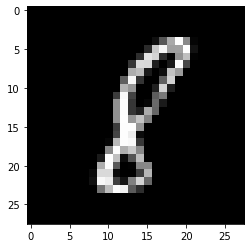

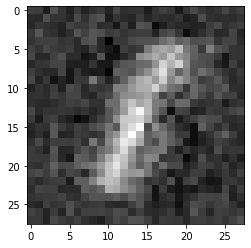

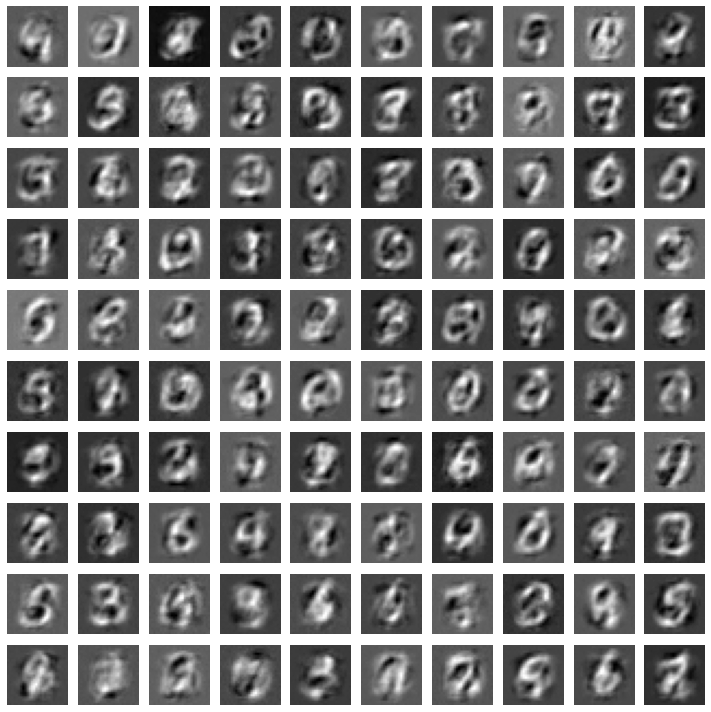

In [216]:
from numpy.random import uniform

idx = int(uniform(0,59999))

im = np.array(x_train[idx,:])
im = im.reshape(28,28)
plt.imshow(im,cmap="gray")
plt.show()

vae_pred = vae.predict(transformed_x[idx:idx+1,:])[2]
im_r = vae_pred[0].reshape(28,28)
plt.imshow(im_r,cmap="gray")
plt.show()


# gen new data

show_images()



def show_images():
    noise = np.random.normal(0, 1, size=(100, 100))
    generated_images = generator.predict(noise)
    generated_images = np.matmul(np.transpose(d.components_),np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [0]:
import matplotlib.pyplot as plt
from numpy.random import uniform
# sanity check - overfit on 4 digit
if(train_only_fours):
  x_train = x_four_digit


# training G and D same amount of times - D should be train on fake and real half
n_d = 1
n_g = 1
n_r = 1

# count the number of non-zeros
def count_support(sparse_mat):
  return (np.count_nonzero(sparse_mat))/sparse_mat.shape[0]

# plots 100 images generated by the Generator
def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



def stop_criteria(fake_x,fake_as_real,real_as_real):
  return np.average(fake_as_real)>=0.49 and (np.abs(np.average(fake_as_real) - np.average(real_as_real))<= 0.05)

def d_ratio_on_fake(fake_x):
  return np.average(discriminator.predict(fake_x))

def d_ratio_on_real(real_x):
  return np.average(discriminator.predict(real_x))

fake_as_real = np.array([])
real_as_real = np.array([])
iters= np.array([])
stop = False
fake_x = 0
g_loss = 0
count_reaches=0

for epoch in range(epochs):  #epochs
    for iter in range(int(steps_per_epoch)):
      i = iter + int(epoch*(steps_per_epoch))
    # train D
      for batch in range(n_d):  #steps_per_epoch
          # stochastic size of real and fake batches
          stoch_batch_size = int(np.random.uniform(1,batch_size))

          noise = np.random.normal(0, 1, size=(stoch_batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          fake_x = generator.predict(noise) # create G(z)
          # fake is (stoch_batch_size,sparse_dim)
          
          fake_x = np.transpose(fake_x)
          # multiply by dict
          fake_x = np.matmul(dictionary_loaded2,fake_x)

          fake_x = np.transpose(fake_x)
          fake_x = fake_x.reshape(stoch_batch_size,img_rows,img_cols,channels)
          # fake_x is of size (stoch_batch_size,rows,cols,channels)

          real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size-stoch_batch_size)] # sample real image
          #remove below to return to FC scheme
          real_x = real_x.reshape(batch_size-stoch_batch_size,img_rows,img_cols,channels)

          #x = np.concatenate((real_x, fake_x))
          
          disc_y = np.zeros(batch_size)
          disc_y[stoch_batch_size:] = 0.9
          # [0 ... 0.9 ...]
          y_real =  disc_y[stoch_batch_size:]
          y_fake = disc_y[:stoch_batch_size]
          if(use_noisy_labels):
            y_real = np.random.uniform(0.9,1,batch_size-stoch_batch_size)
            y_fake = np.random.uniform(0,0.1,stoch_batch_size)

          # train_on_batch recieves data and desired output
          discriminator.trainable = True
          d_loss_real = discriminator.train_on_batch(real_x, y_real)
          d_loss_fake = discriminator.train_on_batch(fake_x, y_fake)
          discriminator.trainable = False
          # sanity check loss - should be 0.5
          if(epoch==0 and batch==0 and iter ==0):
            print("init loss is "+ str(d_loss_real)+" and should be around 1")
          # check stop criteria
          if(epoch>=1 and stop_criteria(fake_x,fake_as_real[-100:],real_as_real[-100:])):
            print("converged in epoch "+str(epoch))
            print("d_ratio_on_fake(fake_x): ",d_ratio_on_fake(fake_x))
            show_images(noise)
            stop = True
            break
      if(stop):
        break
      # print temp results
      fake_as_real = np.append(fake_as_real,d_ratio_on_fake(fake_x))
      iters =  np.append(iters,i)
      real_as_real = np.append(real_as_real,d_ratio_on_real(real_x))
      if(i%1000==0):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        print("results after iter ",i," d_fake_as_real = ",d_ratio_on_fake(fake_x)," d_real_as_real ",d_ratio_on_real(real_x)," support = " ,count_support(generator.predict(noise)))
        show_images(noise)
        plt.plot(iters,fake_as_real,'r')
        plt.plot(iters,real_as_real,'g')
        plt.show()
      # train G
      
      for batch in range(n_g):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        if(use_noisy_labels==True):
          y_gen_1 = np.random.uniform(0.9,1,batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
            
      # train R
      for batch in range(n_r):  #steps_per_epoch
        rand_idxs = np.random.randint(0, x_train.shape[0], size=batch_size)
        x = x_train[rand_idxs] # sample real transformed image
        trans_x = transformed_x[rand_idxs]
        zeros = np.zeros(batch_size*noise_dim)
        zeros = zeros.reshape(batch_size,noise_dim)
        labels = [zeros,trans_x,x]
        r_loss = vae.train_on_batch(trans_x,labels)

    if(stop):
        break
    print(f'Epoch: {epoch} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    show_images(noise)

init loss is 0.17865515 and should be around 1
